# Preprocessing and Quality Control of Xenium Data Across Batches

The Xenium dataset comprises 62 batches. This notebook outlines the steps for preprocessing and performing quality control (QC) on the data. The analysis will include visualizations, dimensionality reduction, and spatial mapping.

---

## Step 1: Overlapping Densities Plot

[Overlapping Densities](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

To begin, overlapping density plots will be generated to visualize and compare the following metrics across batches:
- **Library Depth**: Total counts per cell.
- **Gene Counts**: Number of detected genes per cell.
- **Morphological Features**: Selected morphological metrics.

These plots will help identify potential outliers and assess data distribution across batches.

---

## Step 2: Removing Outlier Cells

Outlier cells with extremely high abundance counts are removed to improve data quality. Cells differing by more than 5 Median Absolute Deviations (MADs) from the median are marked as outliers, as described below:

\[
\text{MAD} = \text{median}\left(\left|X_i - \text{median}(X)\right|\right)
\]

Here, \( X_i \) represents the respective QC metric for a cell. Using this robust filtering method, approximately 14,000 low-quality cells were identified and excluded. This permissive filtering strategy can be revisited after annotating the data.

---

## Step 3: Identifying Batch-Level Outliers Using PCA

To assess whether any batches are clear outliers, PCA is performed on three aggregated metrics:
- **Total Counts**
- **Cell Area**
- **Nucleus Area**

PCA enables visualization of batch distributions and identification of potential batch-level outliers. Upon inspection, no batches appear to be clear outliers, and the data is deemed suitable for further analysis.

---

## Step 4: Log-Normalization and Feature Selection

The data is log-normalized to stabilize variance across features. Highly variable genes are identified, and the top 2000 genes are selected for downstream analysis. This reduces the feature space from 5000 to 2000, making dimensionality reduction and subsequent analyses more efficient.

---

```bash
module load rapids-singlecell 
jupyter-rsc lab --ip localhost --port $PORT1 --no-browser 
```

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
path_andata = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/data_out'
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'

In [4]:
list_andata = os.listdir(path_andata)
# keep only andtat
list_andata_correct = [name for name in list_andata if ".h5ad" in name]

In [5]:
from tqdm import tqdm 
Batch_list = []
batch_uneique = []
for i,p in tqdm(enumerate(list_andata_correct)):
    andata = sc.read_h5ad(os.path.join(path_andata, p))
    rsc.get.anndata_to_GPU(andata)
    batch_name = pd.unique(andata.obs['batch'])[0]
    andata.obs_names = [x + '_' + batch_name for x in andata.obs_names]
    batch_uneique.append(batch_name)
    Batch_list.append(andata)

62it [00:12,  5.09it/s]


In [6]:
import anndata as ad
adata_concat = ad.concat(Batch_list, label="batch", keys=batch_uneique)
adata_concat

AnnData object with n_obs × n_vars = 678423 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch'
    obsm: 'spatial'

In [7]:
genes_name = np.asarray(adata_concat.var_names)
# Check if any gene name starts with 'Mt'
mt_genes = [gene for gene in genes_name if gene.startswith("mt-")]

# Output the result
if mt_genes:
    print(f"Yes, there are {len(mt_genes)} gene(s) starting with 'Mt'.")
else:
    print("No genes start with 'Mt'.")

No genes start with 'Mt'.


In [8]:
df = adata_concat.obs[['total_counts','cell_area','nucleus_area','nucleus_count','batch']]
df.head(3)

,total_counts,cell_area,nucleus_area,nucleus_count,batch
24707_41,723,101.330629,21.087970,1.0,41
24708_41,309,58.883752,34.228439,1.0,41
24709_41,781,135.197817,46.510939,1.0,41


In [9]:
sorted_categories = sorted(df['batch'].cat.categories, key=lambda x: int(x))
df['batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)
sorted_df = df.sort_values(by='batch')

/tmp/ipykernel_89764/3813707652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)


In [10]:
unique_batches_numpy = sorted_df['batch'].cat.categories.to_numpy()


In [11]:
filtered_df = df[df['batch'].isin(["0", "1", "2"])]

# Overlapping Densities Plot - Library Depth


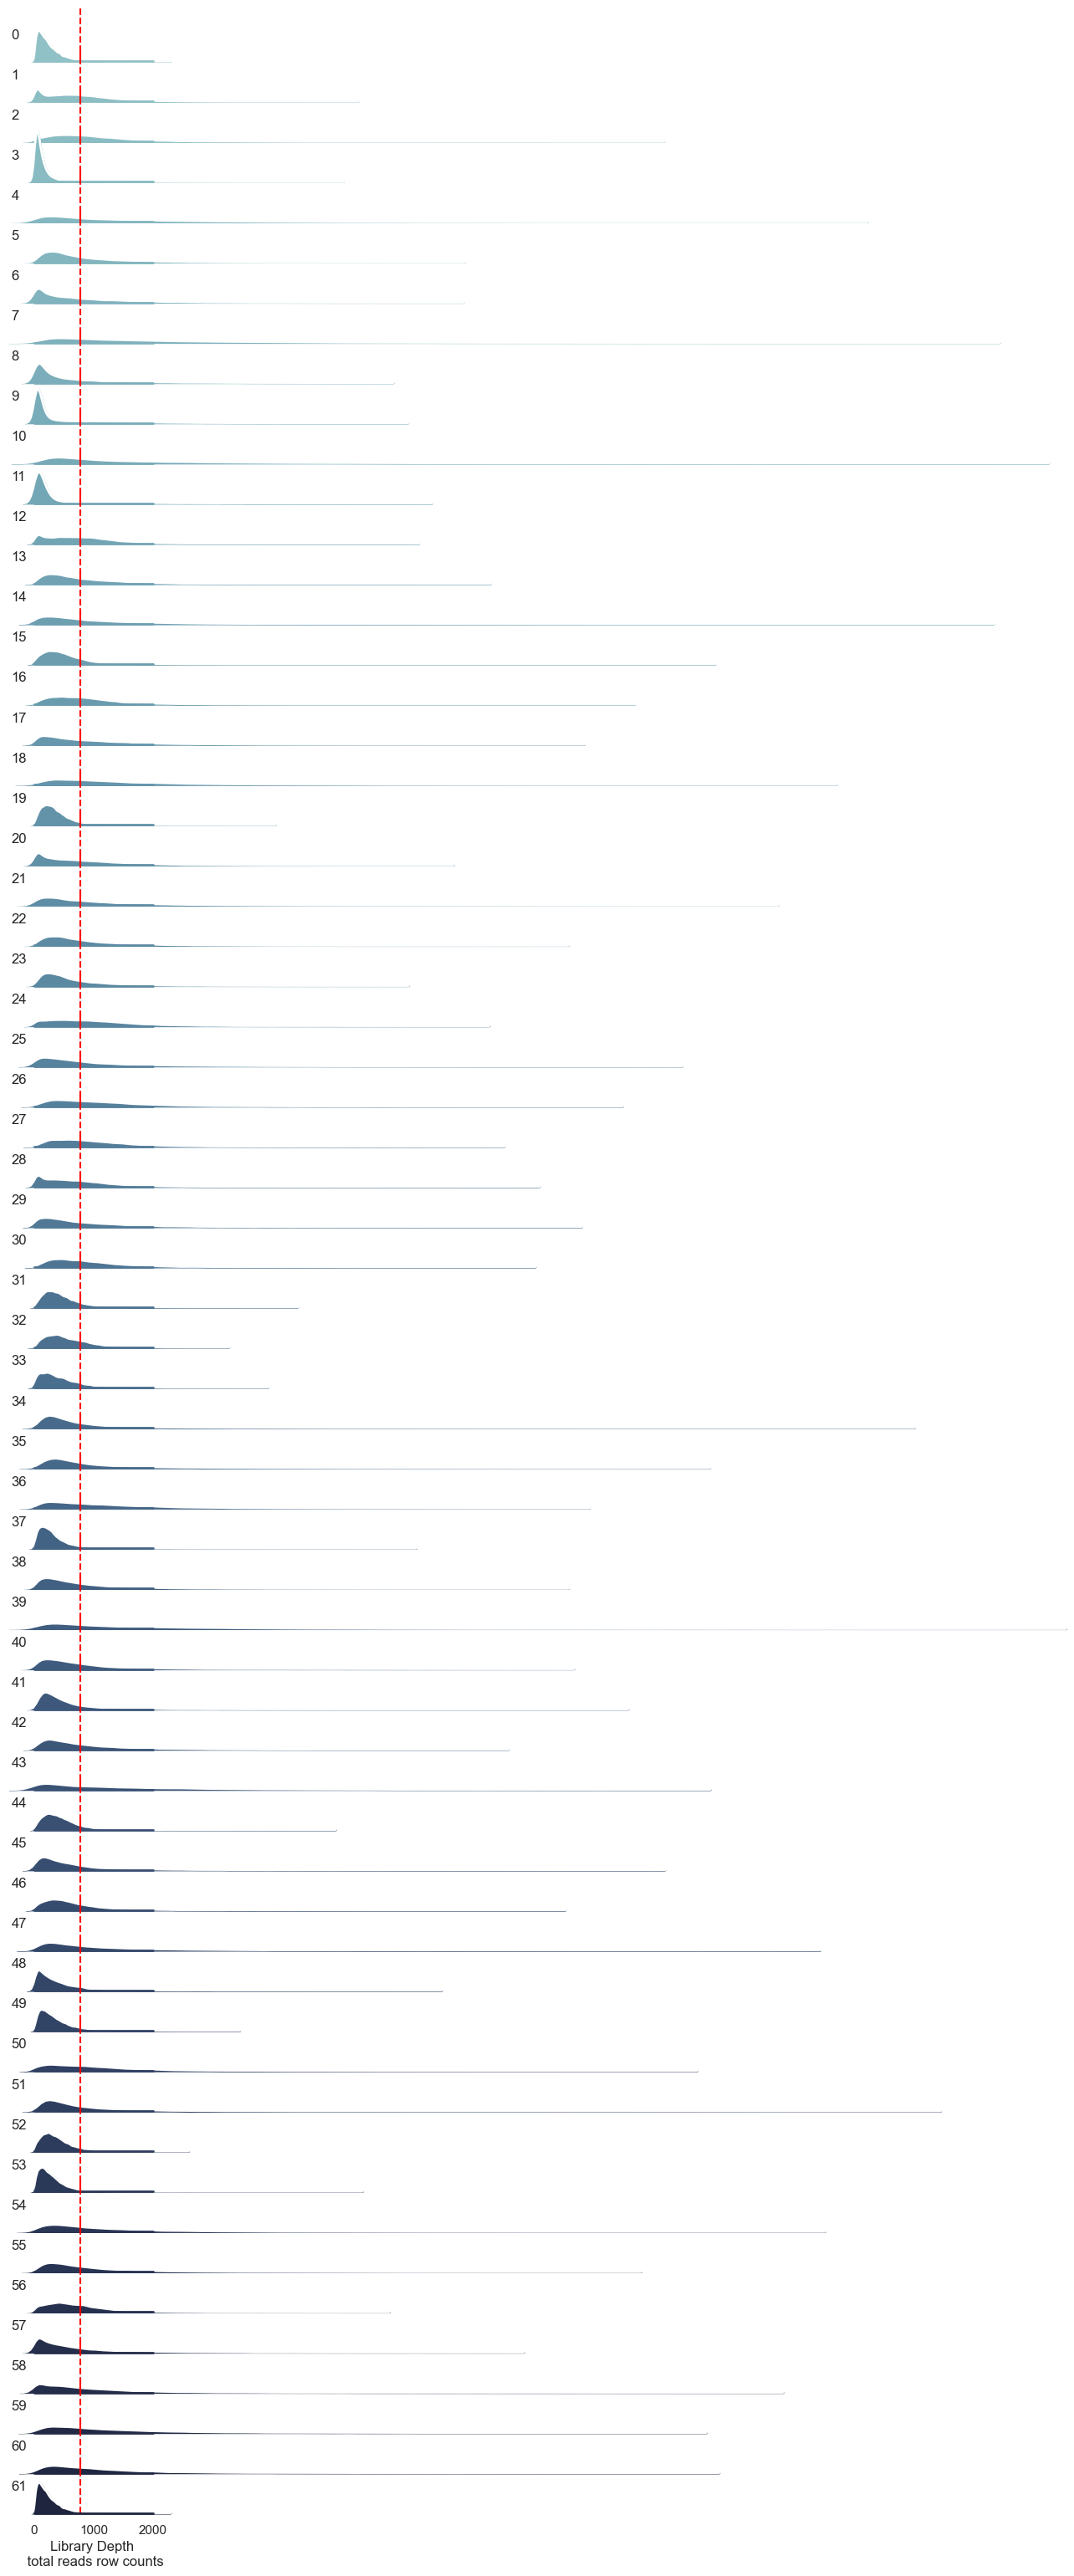

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define palette
pal = sns.cubehelix_palette(len(unique_batches_numpy), rot=-.25, light=.7)

# Initialize FacetGrid
g = sns.FacetGrid(sorted_df, row="batch", hue="batch", aspect=5, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "total_counts", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "total_counts", clip_on=False, color="w", lw=2, bw_adjust=.5)


def add_mean_line(**kwargs):
    mean_value = np.round(np.mean(sorted_df['total_counts'].values),0)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5)

g.map(add_mean_line)
# Add a reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Limit the x-axis
g.set(xlim=(0, 2000))

g.set_titles("")

# Change x-axis label
g.set_axis_labels("Library Depth \n total reads row counts", None)

# Properly align batch labels on the y-axis
for ax, label in zip(g.axes.flat, unique_batches_numpy):
    ax.set_ylabel(f"{label}", rotation=0, ha='left', va='center', labelpad=20)

# Remove unnecessary plot details
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Show plot
plt.show()


### Removing Outlier Cells

From the distribution, we observe that some outlier cells exist with very high abundance counts. These are considered low-quality cells, and the first step is to remove them. I will remove all cells where the outliers are above 5 standard deviations (SD) from the minimum, as shown in the equation below:

$$
\text{MAD} = \text{median}\left(\left|X_i - \text{median}(X)\right|\right)
$$

Here, \( X_i \) represents the respective QC metric of an observation. The MAD is a robust statistic of the variability of the metric. Following this, cells differing by 5 MADs from the median are marked as outliers, a relatively permissive filtering strategy. Similar to [Germain et al., 2020], filtering may be reassessed after annotation.


In [13]:
from scipy.stats import median_abs_deviation
def is_outlier(adata, metric, nmads):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    return np.array(outlier)


In [14]:
adata_concat_filter = adata_concat.copy()

In [15]:
rsc.pp.calculate_qc_metrics(adata_concat_filter)

In [16]:
adata_concat_filter

AnnData object with n_obs × n_vars = 678423 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    obsm: 'spatial'

In [17]:
adata_concat_filter.obs['outlier'] = False
for i in tqdm(range(len(unique_batches_numpy))):
    batch_mask = adata_concat_filter.obs['batch'] == str(i)
    adata_concat_filter.obs.loc[batch_mask,"outlier"] = (is_outlier(adata_concat_filter[batch_mask], "log1p_total_counts", 5) | is_outlier(adata_concat_filter[batch_mask], "log1p_n_genes_by_counts", 5))

100%|██████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 67.17it/s]


In [18]:
adata_concat_filter.obs.outlier.value_counts()

outlier
False    664831
True      13592
Name: count, dtype: int64

In [19]:
adata_concat_filter_cells = adata_concat_filter[(~adata_concat_filter.obs.outlier)].copy()

In [20]:
df = adata_concat_filter_cells.obs[['total_counts','cell_area','nucleus_area','nucleus_count','batch']]
sorted_categories = sorted(df['batch'].cat.categories, key=lambda x: int(x))
df['batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)
sorted_df = df.sort_values(by='batch')

/tmp/ipykernel_89764/2250223723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)


Using the MAD-based outlier detection method, approximately 14,000 cells were identified as outliers.

<div class="alert alert-block alert-success">
<b>Note:</b> MAD is a relatively permissive method for outlier removal. Adjusting cell filtering criteria may be necessary if incorrect mapping is observed.
</div>


First, we examine if any batches are clear outliers by combining the metrics `'total_counts'`, `'cell_area'`, and `'nucleus_area'` using PCA. This allows us to visualize batch distributions and detect potential outliers.

In [21]:
batch_summary = sorted_df.groupby('batch')[['total_counts', 'cell_area', 'nucleus_area']].median()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_summary = scaler.fit_transform(batch_summary)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_summary)

# Add PCA results to a DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['batch'] = batch_summary.index

# Print PCA explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.90574695 0.05872924]


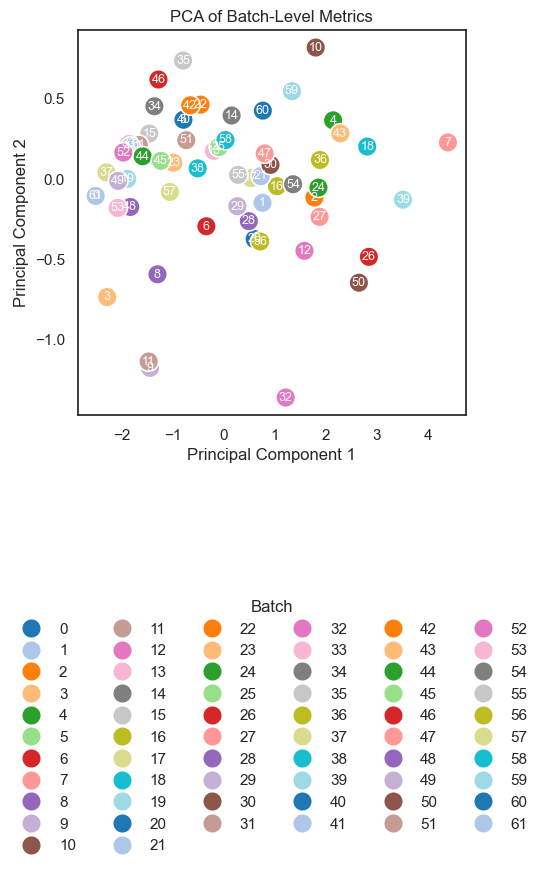

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))

# PCA scatterplot with text annotations inside the points
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='batch', palette='tab20', s=200, legend='full')

# Annotate batch labels inside the points
for i, row in pca_df.iterrows():
    plt.text(row['PC1'], row['PC2'], str(row['batch']), fontsize=9, ha='center', va='center', color='white')

# Customize legend placement
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -1.173),  # Position legend below the plot
    ncol=6,  # Arrange in 6 columns
    frameon=False,  # Remove frame
    title='Batch'
)

# Customize plot appearance
plt.title('PCA of Batch-Level Metrics')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()


Upon inspection, no batches appear to be clear outliers. We then proceed with log-normalizing the data and identifying highly variable genes for downstream analysis.

In [24]:
rsc.pp.filter_cells(adata_concat_filter_cells, min_count=10,qc_var = 'total_counts')
rsc.pp.filter_genes(adata_concat_filter_cells, min_count=5)
rsc.pp.filter_genes(adata_concat_filter_cells, max_count=200_000)

filtered out 738 cells
filtered out 0 genes based on n_cells_by_counts
filtered out 333 genes based on n_cells_by_counts


In [25]:
adata_concat_filter_cells.layers['counts'] = adata_concat_filter_cells.X.copy()
rsc.pp.normalize_total(adata_concat_filter_cells)
rsc.pp.log1p(adata_concat_filter_cells)
adata_concat_filter_cells.layers['log'] = adata_concat_filter_cells.X.copy()

In [26]:
rsc.pp.highly_variable_genes(adata_concat_filter_cells, flavor="seurat_v3", layer="log")

In [27]:
adata_concat_filter_cells

AnnData object with n_obs × n_vars = 664093 × 4673
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts', 'log'

In [28]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
y = adata_concat_filter_cells.var["variances_norm"]
x = adata_concat_filter_cells.var["means"]
y_hat = lowess(y, x, frac=0.1)

Text(0.5, 0, 'Mean Gene Count')

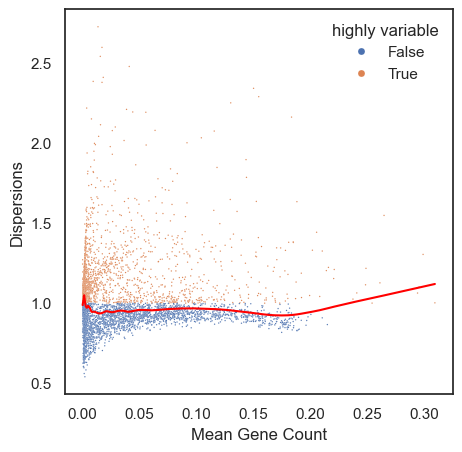

In [29]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=adata_concat_filter_cells.var, x='means', y="variances_norm",s=1,hue = 'highly_variable'
)
plt.plot(y_hat[:, 0], y_hat[:, 1], color='red')
plt.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Position legend below the plot
    ncol=1,  # Arrange in 6 columns
    frameon=False,  # Remove frame
    title='highly variable',
    markerscale = 5
)
plt.ylabel("Dispersions")
plt.xlabel("Mean Gene Count")

In [30]:
adata_concat_filter_cells = adata_concat_filter_cells[:, adata_concat_filter_cells.var["highly_variable"]]
adata_concat_filter_cells.shape

(664093, 2000)

The top 2000 highly variable genes are selected, reducing the feature space from 5000 to 2000, and PCA is performed for dimensionality reduction.

In [84]:
!jupyter nbconvert --to html --no-input "xenium_qc_preprocessing_summary_part_1.ipynb"

/bin/bash: jupyter: command not found


In [31]:
andata_save = adata_concat_filter_cells.copy()

In [33]:
andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg.h5ad"))

In [34]:
andata_save

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts', 'log'